# Imports

In [91]:
import io
import os
import json
import math
import numpy as np
import pandas as pd
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
# Debugging Libraries
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')
#Scikit Libraries
import sklearn
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import mutual_info_score
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
#URL/ File Extraction Libraries
import tarfile
import urllib.request as urllib
from sklearn import preprocessing

np.random.seed(1234)

# Part 1 : IMDB and Logistic Regression

## [IMDB] Data Initialization

In this section, I first download the file from this [link](http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz). I then clean it by filtering out words that are rare, stop, and have high p-values.

### Data Import

In [92]:
# open file
rt = urllib.urlopen("http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz")
tarfile.open(fileobj=rt,mode='r:gz').extractall('./sample_data')

In [93]:
# get the list of words included from 
with open("/content/sample_data/aclImdb/imdb.vocab","r") as file:
  words = [line.rstrip('\n') for line in file]

# Initialize the file names
fnames_train_neg = os.listdir("/content/sample_data/aclImdb/train/neg")
ffnames_train_neg = ["/content/sample_data/aclImdb/train/neg/"+fname for fname in fnames_train_neg]
fnames_train_pos = os.listdir("/content/sample_data/aclImdb/train/pos")
ffnames_train_pos = ["/content/sample_data/aclImdb/train/pos/"+fname for fname in fnames_train_pos]

fnames_train = fnames_train_neg + fnames_train_pos
ffnames_train = ffnames_train_neg + ffnames_train_pos

### Data Cleaning

#### 1.1 Rare and Stopwords
In this first half of the cleaning process, I gather the rare and stopwords from the TRAINING data, then filter those features out from both the TRAINING AND TESTING DATA.

This was the code that I used to find *how many files each word appears in the training data*. 

HOWEVER, since I ran a brute-force algorithm, the completion time of the code took **60 minutes**.

For this reason, I immediately saved the results into a text file after the first and only execution of the code, and now I load it from my Github instead of having to run this 60 min blurb every time. 

```
from sklearn.datasets import load_svmlight_file
from google.colab import files
X,y = load_svmlight_file("/content/sample_data/aclImdb/train/labeledBow.feat", dtype="uint8")

filecount = np.zeros(len(words))
print(filecount.shape)
print(X.getrow(0).toarray()[0].shape)

for i in range(0, X.shape[0]):
  rev_count = X.getrow(i).toarray()[0]
  for j in range(0, rev_count.shape[0]):
    if (rev_count[j] != 0):
      filecount[j]+=1

np.savetxt("filecount_byindex.txt", filecount,fmt="%i")
files.download('/content/filecount_byindex.txt')
```






This code imports my results from running the above code.

In [94]:
# Data of how many files each word appears in.
# filecount_idx : How many files each word appears in (Dictionary, where Key = Word)
f_filecount_arr = urllib.urlopen("https://raw.githubusercontent.com/e-lye/MachineLearning/main/LogisticRegression/processed-data/filecount_byindex.txt")
filecount_arr = np.loadtxt(f_filecount_arr, dtype=int)

filecount_dic_filtered = {}
for i in range(0, filecount_arr.shape[0]):
  if (filecount_arr[i] >= 250 and filecount_arr[i] <= 12500):
    filecount_dic_filtered[i] = filecount_arr[i]

print(f"Total entries before cleaning: {filecount_arr.shape[0]}")
print(f"Total entries that are rare: {np.count_nonzero(filecount_arr < 250)}")
print(f"Total entries that are stopwords: {np.count_nonzero(filecount_arr > 12500)}")
print(f"Total entries after cleaning: {len(filecount_dic_filtered)}")

Total entries before cleaning: 89527
Total entries that are rare: 87756
Total entries that are stopwords: 27
Total entries after cleaning: 1744


After getting the list of rare and stop words, I clean them out from the data and create a dataframe with the filtered information.

The code below is the code ran to create a dataframe without the rare/stop words. After getting the results, I saved it to a CSV as well, and now upload it through my github instead of having to run this code again.

```
from sklearn.datasets import load_svmlight_file
from google.colab import files
X,y = load_svmlight_file("/content/sample_data/aclImdb/train/labeledBow.feat", dtype="uint8")

feature_labels = list(filecount_dic_filtered.keys())

df = pd.DataFrame(columns=feature_labels)

for i_feat in feature_labels:
  df[i_feat] = np.transpose(X.getcol(i_feat).toarray())[0]

df["RATING"]=y
df.to_csv("df_cleaned-pt1.csv")
```



In [95]:
# This imports the data saved from the code above.
url_train = 'https://raw.githubusercontent.com/e-lye/MachineLearning/main/LogisticRegression/processed-data/df_cleaned-pt1.csv'
df_train = pd.read_csv(url_train,index_col=0)

url_test = "https://raw.githubusercontent.com/e-lye/MachineLearning/main/LogisticRegression/processed-data/df_test_cleaned-pt1.csv"
df_test = pd.read_csv(url_test, index_col=0)

#### 1.1 Z-Score & Hypothesis Testing
In this section, I filter out all the words that do not have a significant enough P-Value (p-value > 0.05) before finalizing the cleaned data and variables.

1. I first get the Z-Score and P-Values of the training data.

In [96]:
#scipy.stats used for calculating p values
import scipy.stats 

# Data ARRAY
df_train_array = df_train.to_numpy()
x1_train = df_train_array[:,:-1]
y1_train = df_train_array[:,-1]
N = x1_train.shape[0]
D = 600

# Standardized Data ARRAY
df_train_array_std = df_train_array.copy()
for i in range(0, df_train_array.shape[1]):
  df_train_array_std[:,i]= (df_train_array[:,i] - df_train_array[:,i].mean())/df_train_array[:,i].std()

x1_train_std = df_train_array_std[:,:-1]
y1_train_std = df_train_array_std[:,-1]

# Z scores of all attributes
zscore = np.dot(np.transpose(x1_train_std), y1_train_std) / math.sqrt(N)

# Calculate P values
# Double-Tailed Test: scipy.stats.norm.sf(abs(zscore[i]))*2
# Single-Tailed Test: scipy.stats.norm.sf(abs(zscore[i]))
pvalue = scipy.stats.norm.sf(abs(zscore))*2

2. Next, I isolate all the features with a significant enough pvalue.

In [97]:
#using Null Distribution, we can say that if z-score is greater or less than 1.96, it is significant enough.
np.count_nonzero(abs(zscore) < 1.96)

features_significant = {}

for i in range (0, x1_train.shape[1]):
  if (pvalue[i] < 0.05):
    features_significant[i]=pvalue[i]


features_final = sorted(features_significant, key=features_significant.get)[:D]

3. Lastly, I filter out the insignificant features in the training and testing data. These are the final variables, after cleaning everything.

In [98]:
df_train = df_train[df_train.columns[features_final+[1744]]]
df_test = df_test[df_test.columns[features_final+[1744]]]
df_train_array = df_train.to_numpy()
dfnp_test = df_test.to_numpy()
x1_train = df_train_array[:,:-1]
y1_train = df_train_array[:,-1]
x1_test = dfnp_test[:,:-1]
y1_test = dfnp_test[:,-1]
N = x1_train.shape[0]
D = x1_train.shape[1]

#### Top 20 Words (From Z-Score)

In [99]:
feature_labels = list(filecount_dic_filtered.keys())

x1_train_std = df_train_array_std[:,:-1]
y1_train_std = df_train_array_std[:,-1]

# store significant enough z-scores
zscore_significant = {}
zscore_significant_abs = {}

for i in range (0, x1_train.shape[1]):
  if (abs(zscore[i]) > 1.96):
    zscore_significant[i]=zscore[i]
    zscore_significant_abs[i]= abs(zscore[i])

zscore_sorted = {k: v for k, v in sorted(zscore_significant_abs.items(), key=lambda item: item[1], reverse=True)}
x1_top20 = list(zscore_sorted.keys())[:20]
y_axis = []
x_axis = []

for i in range(len(x1_top20)): 
  x_axis.append(zscore_significant[x1_top20[i]])
  y_axis.append(words[feature_labels[x1_top20[i]]])


<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 432x288 with 0 Axes>

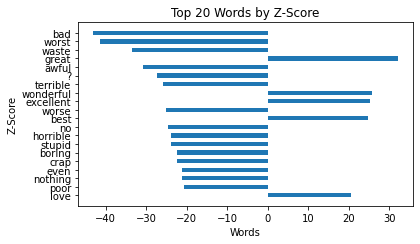

In [100]:
plt.clf()
plt.figure(figsize=(6, 6/(16/9)))
plt.barh(list(reversed(y_axis)), list(reversed(x_axis)),0.5)
plt.title("Top 20 Words by Z-Score")
plt.ylabel("Z-Score")
plt.xlabel("Words")
plt.show

## Logistic Regression
In this section, I run logistic regression on the IMDB data set, to predict whether the rating will be above 5.

In [101]:
logistic = lambda z: 1./ (1 + np.exp(-z))       #logistic function
logit = lambda yhat: yhat/(1-yhat)

def cost_fn(x, y, w):
    N, D = x.shape                                                       
    z = np.dot(x, w)
    J = np.mean(y * np.log1p(np.exp(-z)) + (1-y) * np.log1p(np.exp(z)))  #log1p calculates log(1+x) to remove floating point inaccuracies 
    return J

def gradient(self, x, y):
    N,D = x.shape
    yh = logistic(np.dot(x, self.w))    # predictions  size N
    grad = np.dot(x.T, yh - y)/N        # divide by N because cost is mean over N points
    return grad                         # size D

### Logistic Regression Class

In [102]:
class LogisticRegression:
    
    def __init__(self, add_bias=True, learning_rate=.1, epsilon=1e-4, max_iters=1e5, verbose=False):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon                        #to get the tolerance for the norm of gradients 
        self.max_iters = max_iters                    #maximum number of iteration of gradient descent
        self.verbose = verbose

    def gradient(self, x, y):
        N,D = x.shape
        yh = logistic(np.dot(x, self.w))    # predictions  size N
        grad = np.dot(x.T, yh - y)/N        # divide by N because cost is mean over N points
        return grad,yh
        
    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        self.w = np.zeros(D)
        g = np.inf 
        t = 0
        ce_all = np.zeros(3000)
        # the code snippet below is for gradient descent
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            #ce_all[i] = np.sum(y * np.log1p(np.exp(-a)) + (1-y) * np.log1p(np.exp(a)))
            g ,a= self.gradient(x, y)
            ce_all[t] = np.sum(y * np.log1p(np.exp(-a)) + (1-y) * np.log1p(np.exp(a)))
            self.w = self.w - self.learning_rate * g 
            t += 1
        
        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight shape found: {self.w.shape}')
            ce_all = ce_all[:t]
            ce_all = preprocessing.scale(ce_all)
            plt.clf()
            plt.figure(figsize=((16/9)*3.6,3.6))
            plt.plot(ce_all)
            plt.ylabel("Cross entropy")
            plt.xlabel("iteration")
            #plt.title(f"True w={w_true}; Estimated w={round(w.astype(float)[0],2)}")
            
            plt.title("CE Loss for Logistic Regression")
            # plt.show()
            plt.savefig('ce_iteration.png', bbox_inches="tight", dpi=300)
        return self
    
    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = logistic(np.dot(x,self.w))            #predict output
        return yh

# LogisticRegression.gradient = gradient             #initialize the gradient method of the LogisticRegression class with gradient function

### IMDB Dataset Application


I first calculate and visualize the effect size of the features. 

terminated after 1000 iterations, with norm of the gradient equal to 0.0016823878551570667
the weight shape found: (601,)
       77       240       427       83       368        46       373      369      309       422      115        55       503       363       344       584        53       156       328      114       225      459       760       109       407      437      392      493       622       111        40       267       856      297       813      870      1103        88       221      509      748      529       133      1179      1014      79       598       149      1197       439       906      897      1270      116      1606       52        97      489      190       868      229       216       409     1251        94     204       71       294      691       42      340       581       37       734      1285      150        23        95       270    1616        39      916     1243     1287        60       224      174     950      488       179       955       70

pandas.core.frame.DataFrame

<Figure size 432x288 with 0 Axes>

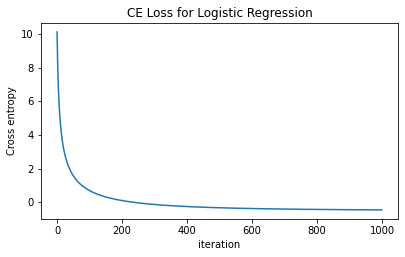

In [103]:
x1_train = df_train_array[:,:-1]
y1_train = df_train_array[:,-1]
x1_test = dfnp_test[:,:-1]
y1_test = dfnp_test[:,-1]

y1_train_binary = (y1_train > 5).astype(int)
y1_test_binary = (y1_test > 5).astype(int)
x1_train_std = StandardScaler().fit(x1_train).transform(x1_train)
x1_test_std = StandardScaler().fit(x1_test).transform(x1_test)

logitreg = LogisticRegression(max_iters=1e3,verbose = True)
fit = logitreg.fit(x1_train_std, y1_train_binary)

effect_size = pd.DataFrame(fit.w[:(len(fit.w)-1)]).transpose()
effect_size.columns = df_train.drop(["RATING"],axis = 1).columns
print(effect_size.to_string(index=False))
type(effect_size)


<Figure size 432x288 with 0 Axes>

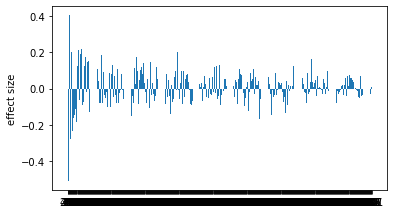

<Figure size 432x288 with 0 Axes>

In [104]:
plt.clf()
plt.figure(figsize=(6, 6/(16/9)))
plt.bar(list(effect_size.columns.values), effect_size.stack().tolist())
plt.ylabel("effect size")
plt.show()
plt.savefig("effect_size.png", bbox_inches='tight', dpi=300)

### Model Evaluation
In this section, I evaluate the model and compare it against KNN's accuracy.

#### Classification Accuracy
Logistic Regression and KNN.

In [105]:
y1_train_log_pred = fit.predict(x1_train_std)
y1_test_log_pred = fit.predict(x1_test_std)

# Threshold predictions
y1_train_log_pred = (y1_train_log_pred > 0.5).astype(int)
y1_test_log_pred = (y1_test_log_pred > 0.5).astype(int)

# accuracy = correctly classified / total classified
acc_train = sum(y1_train_log_pred == y1_train_binary)/len(y1_train_binary)
acc_test = sum(y1_test_log_pred==y1_test_binary)/len(y1_test_binary)
print(f"train accuracy: {acc_train:.5f}; test accuracy: {acc_test:.5f}")

train accuracy: 0.87952; test accuracy: 0.86676


In [106]:
KNN = KNeighborsClassifier(n_neighbors=5)
KNN.fit(x1_train_std, y1_train_binary) #comparison to logistic regression

# Predict
y1_train_knn_pred = KNN.predict(x1_train_std)
y1_test_knn_pred = KNN.predict(x1_test_std)

# accuracy = correctly classified / total classified
acc_train = sum(y1_train_knn_pred == y1_train_binary)/len(y1_train_binary)
acc_test = sum(y1_test_knn_pred==y1_test_binary)/len(y1_test_binary)
print(f"train accuracy: {acc_train:.5f}; test accuracy: {acc_test:.5f}")

train accuracy: 0.80516; test accuracy: 0.69784


#### Top 20 Words (From W-Coefficient Values)

<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 432x288 with 0 Axes>

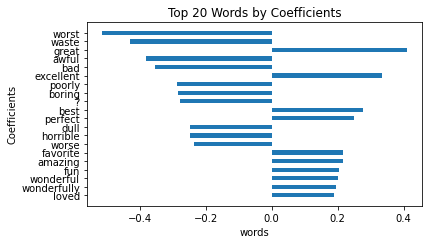

In [107]:
word_ind = [eval(i) for i in df_train.columns[:-1].tolist()]
w = fit.w[:-1]

#positive
ind_pos10 = np.argpartition(w, -10)[-10:]
#negative
ind_neg10 = np.argpartition(w, 10)[:10]
# positive + negative
ind_top20 = np.concatenate((ind_pos10, ind_neg10))

xy_dict = {}
for idx in ind_top20:
  xy_dict[words[word_ind[idx]]] = w[idx]
  
xy_dict_sort = {k: v for k, v in sorted(xy_dict.items(), key=lambda item: abs(item[1]))}

plt.clf()
plt.figure(figsize=(6, 6/(16/9)))
plt.barh(list(xy_dict_sort.keys()), list(xy_dict_sort.values()),0.5)
plt.title("Top 20 Words by Coefficients")
plt.ylabel("Coefficients")
plt.xlabel("words")
plt.show

#### ROC Curve
Logistic Regression and KNN.

I first run AUROC analysis of Logistic regression vs. KNN on 100% of the data. 

After that, I run an AUROC analysis of Logistic regression on varying percentages of the original data set.

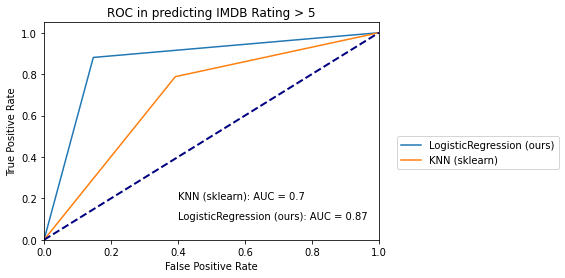

In [108]:
from sklearn.metrics import roc_curve, roc_auc_score

perf = {}

fpr_log, tpr_log, _ = roc_curve(y1_test_binary, y1_test_log_pred)
auroc_log = roc_auc_score(y1_test_binary, y1_test_log_pred)
perf["LogisticRegression (ours)"] = {'fpr':fpr_log, 'tpr':tpr_log, 'auroc':auroc_log}

fpr_knn, tpr_knn, _ = roc_curve(y1_test_binary, y1_test_knn_pred)
auroc_knn = roc_auc_score(y1_test_binary, y1_test_knn_pred)
perf["KNN (sklearn)"] = {'fpr':fpr_knn, 'tpr':tpr_knn, 'auroc':auroc_knn}

plt.clf()
i = 0
for model_name, model_perf in perf.items():
    plt.plot(model_perf['fpr'], model_perf['tpr'],label=model_name)
    plt.text(0.4, i+0.1, model_name + ': AUC = '+ str(round(model_perf['auroc'],2)))
    i += 0.1

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC in predicting IMDB Rating > 5')
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="upper left")
plt.savefig("roc_curve.png", bbox_inches='tight', dpi=300)

In [109]:
splitpercent = np.array([0.2, 0.4, 0.6, 0.8, 1.0])

x1_train_std #train
x1_test_std #predict
y1_train_binary
aurocs = []
logitreg = LogisticRegression(max_iters=1e3)

for pc in splitpercent:
  stop_idx = int(x1_train_std.shape[0] * pc)
  x1_train_roc = x1_train_std[:stop_idx,:]
  y1_train_roc = y1_train_binary[:stop_idx]

  fit = logitreg.fit(x1_train_roc, y1_train_roc)
  y1_test_roc_pred = fit.predict(x1_test_std)
  y1_test_roc_pred = (y1_test_roc_pred > 0.5).astype(int)
  
  fpr_roc, tpr_roc, _ = roc_curve(y1_test_binary, y1_test_roc_pred)
  aurocs.append(roc_auc_score(y1_test_binary, y1_test_roc_pred))

<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 432x288 with 0 Axes>

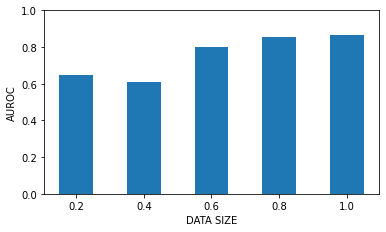

In [110]:
plt.clf()
plt.figure(figsize=(6, 6/(16/9)))
plt.bar(splitpercent, aurocs, 0.1)
plt.ylim([0,1])
plt.ylabel("AUROC")
plt.xlabel("DATA SIZE")
plt.show

# Part 2 : News and Multiclass Regression

## [News Group] Data Initialization

### Data Imports

In [111]:
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from scipy import sparse

# Training Data
categories = ['comp.graphics', 'rec.sport.hockey', 'sci.med', 'soc.religion.christian']
news_data_train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=10, remove =(['headers', 'footers', 'quotes']))
count_vect_train = sklearn.feature_extraction.text.CountVectorizer(max_df=0.50,min_df=0.01)
X_train_counts = count_vect_train.fit_transform(news_data_train.data)

# Testing Data
news_data_test = fetch_20newsgroups(subset='test',categories=categories, shuffle=True, random_state=42,remove =(['headers', 'footers', 'quotes']))
count_vect_test = sklearn.feature_extraction.text.CountVectorizer()
X_test_counts = count_vect_test.fit_transform(news_data_test.data)
#one_hot the y column

#train
y_train_50 = np.zeros((news_data_train.target.size, news_data_train.target.max() + 1))
y_train_50[np.arange(news_data_train.target.size), news_data_train.target] = 1

#test onehot
y2_test = np.zeros((news_data_test.target.size, news_data_test.target.max() + 1))
y2_test[np.arange(news_data_test.target.size), news_data_test.target] = 1


### Data Cleaning
In this section, I clean the dataset through their tfidf, since the rare and stopwords were filtered already above via:


```
sklearn.feature_extraction.text.CountVectorizer(max_df=0.50,min_df=0.01)
```

In [112]:
#get tfidf
tfidf_transformer = TfidfTransformer(use_idf=False)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_idf_array = X_train_tfidf.toarray()
#K many features
K = 100
#get MI
ind = []
MI = np.zeros(X_train_idf_array.shape[1])
#for each class(4)
for c in range(y_train_50.shape[1]):
  #for each feature
  for x in range(X_train_idf_array.shape[1]):
    MI[x] = metrics.mutual_info_score(X_train_idf_array[:,x],y_train_50[:,c])
  #get top 100 features
  ind = np.append(ind,np.argpartition(MI, -K)[-K:])

#remove dup, then convert to int
ind = list(map(int, list(set(ind))))
#get x trained filtered
X_train_idf_filtered = X_train_idf_array[:,ind]

#words for features
x_trained_words = count_vect_train.get_feature_names_out()[ind]


# Filter out the words for X_test
X_train_counts_filtered = np.zeros((X_train_idf_array.shape[0], len(ind)))
X_test_counts_filtered = np.zeros((X_test_counts.shape[0], len(ind)))

for i in range(0, len(x_trained_words)):
  word = x_trained_words[i]
  train_index = count_vect_train.get_feature_names().index(word)
  test_index = count_vect_test.get_feature_names().index(word)
  X_train_counts_filtered[:,i] = np.transpose(X_train_counts.getcol(train_index).toarray())[0]
  X_test_counts_filtered[:,i] = np.transpose(X_test_counts.getcol(test_index).toarray())[0]

#x2_test.shape
#get tfidf for x test
tfidf_transformer2 = TfidfTransformer(use_idf=False)

X_train_idf_filtered = tfidf_transformer2.fit_transform(X_train_counts_filtered)
X_train_idf_filtered_array = X_train_idf_filtered.toarray()

X_test_idf_filtered = tfidf_transformer2.fit_transform(X_test_counts_filtered)
X_test_idf_filtered_array = X_test_idf_filtered.toarray()

## Multiclass Regression

In this section, I run the multi-class regression on the cleaned 20newsgroupdata, before doing analysis on the prediction results.

### Multiclass Regression Class

In [113]:
def evaluate(y, y_pred):
    accuracy = sum(y_pred.argmax(axis=1) == y.argmax(axis=1))
    accuracy = accuracy / y.shape[0]
    return accuracy
class Multinomial_logistic:
    def __init__(self, nFeatures, nClasses):
        self.W = np.random.rand(nFeatures, nClasses)

    def predict(self, X):
        y_pred = np.exp(np.matmul(X, self.W))
        return y_pred / y_pred.sum(axis=1).reshape(X.shape[0], 1)

    def grad(self, X, y):
        return np.matmul(X.transpose(), self.predict(X) - y)

    def ce(self, X, y):
        return -np.sum(y * np.log(self.predict(X)))

    # modify it to add stopping criteria (what can you think of?)
    def fit(self, X, y, X_valid=None, y_valid=None, lr=0.005, niter=100):
        losses_train = np.zeros(niter)
        losses_valid = np.zeros(niter)
        for i in range(niter):
            self.W = self.W - lr * self.grad(X, y)
            loss_train = self.ce(X, y)
            losses_train[i] = loss_train
            if X_valid is not None and y_valid is not None:
                loss_valid = self.ce(X_valid, y_valid)
                losses_valid[i] = loss_valid
                #print(f"iter {i}: {loss_train:.3f}; {loss_valid:.3f}")
            #else:
                #print(f"iter {i}: {loss_train:.3f}")
        return losses_train, losses_valid

    def check_grad(self, X, y):
        N, C = y.shape
        D = X.shape[1]

        diff = np.zeros((D, C))

        W = self.W.copy()

        for i in range(D):
            for j in range(C):
                epsilon = np.zeros((D, C))
                epsilon[i, j] = np.random.rand() * 1e-4

                self.W = self.W + epsilon
                J1 = self.ce(X, y)
                self.W = W

                self.W = self.W - epsilon
                J2 = self.ce(X, y)
                self.W = W

                numeric_grad = (J1 - J2) / (2 * epsilon[i, j])
                derived_grad = self.grad(X, y)[i, j]

                diff[i, j] = np.square(derived_grad - numeric_grad).sum() / \
                             np.square(derived_grad + numeric_grad).sum()

        # print(diff)
        return diff.sum()


In [114]:
#includes early stopping bby check avg validation loss for lookback iter if greater than previousstop
class Multi_with_early_stopping(Multinomial_logistic):
  def fit(self, X,y,X_valid=None,y_valid=None,lr=0.005,niter=100,early_stopping = False, look_back = 1):
        losses_train = np.zeros(niter)
        losses_valid = np.zeros(niter)
        for i in range(niter):
            self.W = self.W - lr * self.grad(X, y)
            loss_train = self.ce(X, y)
            losses_train[i] = loss_train
            if X_valid is not None and y_valid is not None:
                loss_valid = self.ce(X_valid, y_valid)
                losses_valid[i] = loss_valid
                #print(f"iter {i}: {loss_train:.3f}; {loss_valid:.3f}")
                if early_stopping and i>look_back:
                  loss_is_greater = (loss_valid > np.mean(losses_valid[i-look_back:i]))#compare current validation loss with before
                  if loss_is_greater:
                    print('\nEarly stoppng at iter{} due to increase in validation loss'.format(i))
                    losses_train = losses_train[:i]
                    losses_valid = losses_valid[:i]
                    break
            else:
                #print(f"iter {i}: {loss_train:.3f}")
                pass
        return losses_train, losses_valid    

### Predictions

In [115]:

#split training into training and valid
X_train_pre, X_valid, y_train, y_valid = model_selection.train_test_split(
    X_train_idf_filtered_array, y_train_50, test_size = 0.5, random_state=1, shuffle=False)
N, C = y_train.shape
print(X_train_pre.shape)
#X_train = preprocessing.scale(X_train) # standardize input data
X_train = np.c_[X_train_pre, np.ones(N)] # add one column to learn the linear intercept
print(X_train.shape)
#X_valid = preprocessing.scale(X_valid)
X_valid = np.c_[X_valid, np.ones(X_valid.shape[0])]
#x2_test = preprocessing.scale(x2_test_idf_array)
x2_test = np.c_[X_test_idf_filtered_array , np.ones(X_test_idf_filtered_array .shape[0])]
D = X_train.shape[1]

(1188, 134)
(1188, 135)


In [116]:
mlr = Multinomial_logistic(D, C)
print(mlr.check_grad(X_train, y_train))
ce_train, ce_valid = mlr.fit(X_train, y_train, X_valid, y_valid,lr = 0.001, niter=1500)
optimal_niter = ce_valid.argmin()

2.5254180343200126e-14


In [117]:
mlr.predict(X_train)

array([[0.03131463, 0.00460733, 0.08226424, 0.8818138 ],
       [0.07207228, 0.47780737, 0.1370909 , 0.31302945],
       [0.0535228 , 0.08139114, 0.55236786, 0.31271819],
       ...,
       [0.03547446, 0.56918939, 0.24154721, 0.15378894],
       [0.12262429, 0.84376889, 0.01180627, 0.02180054],
       [0.06696931, 0.03597398, 0.31390722, 0.58314948]])

In [118]:
y_train

array([[0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]])

train acc before optimal iter 0.797979797979798
valid acc before optimal iter 0.7291841883936081
test acc before optimal iter 0.6972187104930467


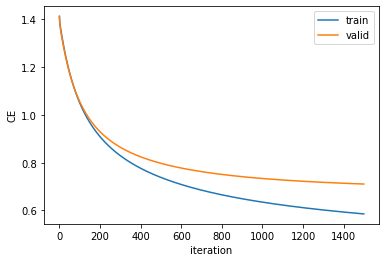

In [119]:
train_accuracy = evaluate(mlr.predict(X_train), y_train)
valid_accuracy = evaluate(mlr.predict(X_valid), y_valid)
test_accuracy = evaluate(mlr.predict(x2_test), y2_test)
print("train acc before optimal iter",train_accuracy)
print("valid acc before optimal iter",valid_accuracy)
print("test acc before optimal iter",test_accuracy)
plt.clf()
plt.plot(ce_train/X_train.shape[0], label='train')
plt.plot(ce_valid/X_valid.shape[0], label='valid')
plt.xlabel("iteration")
plt.ylabel("CE")
plt.legend()
# plt.show()
plt.savefig("training_ce.png", bbox_inches="tight", dpi=300)

#### Use Optimal Niter

In [120]:
mlr = Multinomial_logistic(D, C)
optimal_niter = ce_valid.argmin()
ce_train, ce_valid = mlr.fit(X_train, y_train, X_valid, y_valid,lr = 0.001, niter=optimal_niter) # retrain the model using best niter

train acc after optimal iter 0.7996632996632996
valid acc after optimal iter 0.7308662741799832
test acc after optimal iter 0.695322376738306


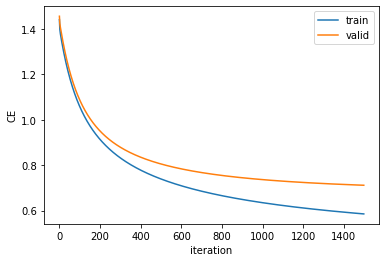

In [121]:
train_accuracy = evaluate(mlr.predict(X_train), y_train)
valid_accuracy = evaluate(mlr.predict(X_valid), y_valid)
test_accuracy = evaluate(mlr.predict(x2_test), y2_test)
print("train acc after optimal iter",train_accuracy)
print("valid acc after optimal iter",valid_accuracy)
print("test acc after optimal iter",test_accuracy)
plt.clf()
plt.plot(ce_train/X_train.shape[0], label='train')
plt.plot(ce_valid/X_valid.shape[0], label='valid')
plt.xlabel("iteration")
plt.ylabel("CE")
plt.legend()
# plt.show()
plt.savefig("training_ce.png", bbox_inches="tight", dpi=300)

#### Use Early Stopping

In [122]:
mlr = Multi_with_early_stopping(D,C)
## fit model
ce_train, ce_valid = mlr.fit(X_train, y_train, X_valid, y_valid,lr=0.005, niter=100000,early_stopping=True,look_back = 5)


Early stoppng at iter736 due to increase in validation loss


train acc with early stopping 0.8215488215488216
valid acc with early stopping 0.7333894028595458
test acc with early stopping 0.706700379266751


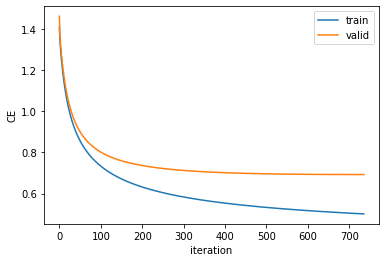

In [123]:
plt.clf()
train_accuracy100 = evaluate(mlr.predict(X_train), y_train)
valid_accuracy100 = evaluate(mlr.predict(X_valid), y_valid)
test_accuracy100 = evaluate(mlr.predict(x2_test), y2_test)
print("train acc with early stopping",train_accuracy100)
print("valid acc with early stopping",valid_accuracy100)
print("test acc with early stopping",test_accuracy100)
plt.plot(ce_train/X_train.shape[0], label='train')
plt.plot(ce_valid/X_valid.shape[0], label='valid')
plt.xlabel("iteration")
plt.ylabel("CE")
plt.legend()
# plt.show()
plt.savefig("training_ce.png", bbox_inches="tight", dpi=300)

####Check Gradient

In [124]:
#check gradient
print(mlr.check_grad(X_train, y_train))

6.483660372721892e-07


### Comparison to K-nearest neighbours

In [125]:
x2_train_knn = X_train_idf_filtered_array.copy()
x2_test_knn = X_test_idf_filtered_array.copy()
y2_train_knn = np.where(y_train_50==1)[1]
y2_test_knn = np.where(y2_test==1)[1]

In [126]:
KNN = KNeighborsClassifier(n_neighbors=5)
KNN.fit(x2_train_knn, y2_train_knn) #comparison to multiclass regression

y2_train_knn_pred = KNN.predict(x2_train_knn)
y2_test_knn_pred = KNN.predict(x2_test_knn)

print("Multiclass training accuracy:",metrics.accuracy_score(y2_train_knn, y2_train_knn_pred))
print("Multiclass testing accuracy:",metrics.accuracy_score(y2_test_knn, y2_test_knn_pred))

Multiclass training accuracy: 0.7210769877997476
Multiclass testing accuracy: 0.54551201011378


### Heatmap

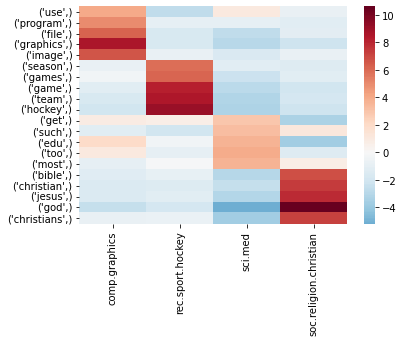

In [127]:
from seaborn import heatmap
W_hat = mlr.W
#change w to have 5 rows most positive for each class
W_top_five = []
heatind = []
for c in range(W_hat.shape[1]):
  heatind.append(np.argpartition(W_hat[:,c], -5)[-5:])
  W_top_five.append(W_hat[np.argpartition(W_hat[:,c], -5)[-5:]])

W_top_five = np.array(W_top_five)
W_top_five=np.reshape(W_top_five,(20,4))
heatind = np.array(heatind)
heatind=np.reshape(heatind,(20,1))
W_hat_transformed_df = pd.DataFrame(W_top_five, columns=categories, index=x_trained_words[heatind])
hmp = heatmap(W_hat_transformed_df, cmap='RdBu_r', center=0)
fig = hmp.get_figure()
fig.savefig("W_hat.png")

### Varying Size of Training Data


Early stoppng at iter582 due to increase in validation loss
train acc with early stopping0.9240506329113924,iteration 3
valid acc with early stopping0.607232968881413,iteration 3
test acc with early stopping0.5790139064475348,iteration 3

Early stoppng at iter511 due to increase in validation loss
train acc with early stopping0.8652631578947368,iteration 3
valid acc with early stopping0.6719932716568545,iteration 3
test acc with early stopping0.6479140328697851,iteration 3

Early stoppng at iter484 due to increase in validation loss
train acc with early stopping0.8469101123595506,iteration 3
valid acc with early stopping0.6896551724137931,iteration 3
test acc with early stopping0.6814159292035398,iteration 3

Early stoppng at iter577 due to increase in validation loss
train acc with early stopping0.8442105263157895,iteration 3
valid acc with early stopping0.7073170731707317,iteration 3
test acc with early stopping0.690897597977244,iteration 3


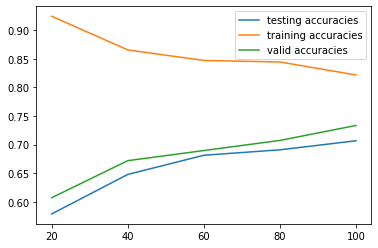

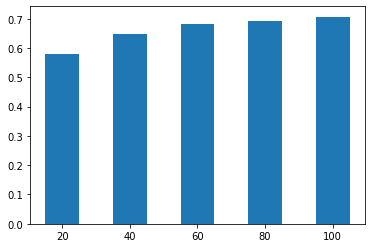

In [128]:
#vary size of training set by 20,40,60,80%
#training set
#20%
X2_train20, _, y2_train20, _ = model_selection.train_test_split(
    X_train, y_train, train_size = 0.2, random_state=1, shuffle=False)
#40%
X2_train40, _, y2_train40, _ = model_selection.train_test_split(
    X_train, y_train, train_size = 0.4, random_state=1, shuffle=False)
#60%
X2_train60, _, y2_train60, _ = model_selection.train_test_split(
    X_train, y_train, train_size = 0.6, random_state=1, shuffle=False)
#20%
X2_train80, _, y2_train80, _ = model_selection.train_test_split(
    X_train, y_train, train_size = 0.8, random_state=1, shuffle=False)

x_train_sets = [X2_train20,X2_train40,X2_train60,X2_train80]
y_train_sets = [y2_train20,y2_train40,y2_train60,y2_train80]

N, C = y_train.shape
test_acc = []
valid_acc = []
train_acc = []
for s in range(4):
  N, C = y_train_sets[s].shape
  D = x_train_sets[s].shape[1]
  mlr = Multi_with_early_stopping(D,C)
  ce_train, ce_valid = mlr.fit(x_train_sets[s], y_train_sets[s], X_valid, y_valid,lr=0.005, niter=100000,early_stopping=True,look_back = 5)
  train_accuracy = evaluate(mlr.predict(x_train_sets[s]), y_train_sets[s])
  train_acc.append(train_accuracy)
  valid_accuracy = evaluate(mlr.predict(X_valid), y_valid)
  valid_acc.append(valid_accuracy)
  test_accuracy = evaluate(mlr.predict(x2_test), y2_test)
  test_acc.append(test_accuracy)
  print(f"train acc with early stopping{train_accuracy},iteration {c}")
  print(f"valid acc with early stopping{valid_accuracy},iteration {c}")
  print(f"test acc with early stopping{test_accuracy},iteration {c}")

test_acc.append(test_accuracy100)
train_acc.append(train_accuracy100)
valid_acc.append(valid_accuracy100)

x_label = [20,40,60,80,100]
plt.plot(x_label, test_acc, label = "testing accuracies")
plt.plot(x_label, train_acc, label = "training accuracies")
plt.plot(x_label, valid_acc, label = "valid accuracies")
plt.xticks(x_label)
plt.legend()
plt.show()
plt.bar(x_label,test_acc,width = 10)
plt.xticks(x_label)
plt.show()

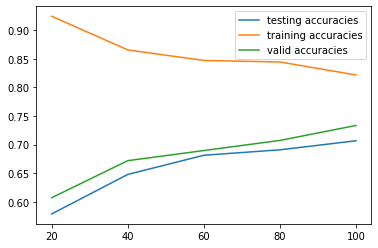

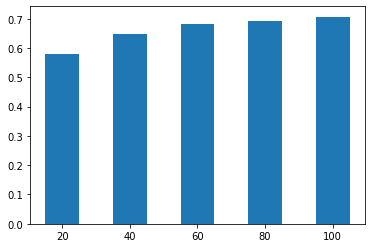

In [129]:
x_label = [20,40,60,80,100]
plt.plot(x_label, test_acc, label = "testing accuracies")
plt.plot(x_label, train_acc, label = "training accuracies")
plt.plot(x_label, valid_acc, label = "valid accuracies")
plt.xticks(x_label)
plt.legend()
plt.show()
plt.bar(x_label,test_acc,width = 10)
plt.xticks(x_label)
plt.show()

# Additional Experiments

##Ridge Classifier

###News Data

In [130]:
from sklearn.linear_model import RidgeClassifier
rig = RidgeClassifier(alpha = 0.01).fit(X_train, y_train)
rig.score(X_train, y_train)

test_accuracy = evaluate(rig.predict(x2_test), y2_test)
train_accuracy = evaluate(rig.predict(X_train), y_train)
print("Ridge CLassifier accuracy on training data",train_accuracy )
print("Ridge Classifier accuracy on test data",test_accuracy)

Ridge CLassifier accuracy on training data 0.7070707070707071
Ridge Classifier accuracy on test data 0.622629582806574


In [131]:
rig = RidgeClassifier(alpha = 0.01,max_iter = 10000).fit(x1_train_std, y1_train_binary)
rig.score(x1_train_std, y1_train_binary)

test_accuracy = np.count_nonzero(rig.predict(x1_test_std) == y1_test_binary) / y1_test_binary.shape[0]
train_accuracy = np.count_nonzero(rig.predict(x1_train_std) == y1_train_binary) / y1_train_binary.shape[0]
print("Ridge CLassifier accuracy on training data",train_accuracy )
print("Ridge Classifier accuracy on test data",test_accuracy)

Ridge CLassifier accuracy on training data 0.87172
Ridge Classifier accuracy on test data 0.86316


##Lasso Classifier

###News Data

In [132]:
from sklearn import linear_model

lasso = linear_model.Lasso(alpha=0.001).fit(X_train, y_train)
test_accuracy = evaluate(lasso.predict(x2_test), y2_test)
train_accuracy = evaluate(lasso.predict(X_train), y_train)
print("Lasso Classifier accuracy on training data",train_accuracy )
print("Lasso Classifier accuracy on test data",test_accuracy)

Lasso Classifier accuracy on training data 0.7744107744107744
Lasso Classifier accuracy on test data 0.7092288242730721


In [133]:
lasso = linear_model.Lasso(alpha=0.00001).fit(x1_train_std, y1_train_binary)
test_accuracy = np.count_nonzero((lasso.predict(x1_test_std) > 0.5).astype(int) == y1_test_binary) / y1_test_binary.shape[0]
train_accuracy = np.count_nonzero((lasso.predict(x1_train_std) > 0.5).astype(int) == y1_train_binary) / y1_train_binary.shape[0]
print("Lasso Classifier accuracy on training data",train_accuracy)
print("Lasso Classifier accuracy on test data",test_accuracy)

Lasso Classifier accuracy on training data 0.8718
Lasso Classifier accuracy on test data 0.86312
